In [1]:
import numpy as np
import pandas as pd
import os
import math
from datetime import datetime

from matplotlib import pyplot as plt
import matplotlib.style as style

In [2]:
data_dir = "/Users/lixinhui/Dropbox (MIT)/17 Fall/A-6.419/Pset6/Data"
filename = "usa.csv"
input_path = os.path.join(data_dir, '')
data = pd.read_csv(input_path + filename, header = 0)
data.head()

,date,BPP,CPI
0,7/1/08,100.000,100.0
1,7/2/08,99.887,100.0
2,7/3/08,99.867,100.0
3,7/4/08,99.845,100.0
4,7/5/08,99.893,100.0


In [6]:
data['date1'] = data.apply(lambda row: datetime.strptime(row['date'], '%x'), axis=1) 
data.head()

,date,BPP,CPI,date1
0,7/1/08,100.000,100.0,2008-07-01
1,7/2/08,99.887,100.0,2008-07-02
2,7/3/08,99.867,100.0,2008-07-03
3,7/4/08,99.845,100.0,2008-07-04
4,7/5/08,99.893,100.0,2008-07-05


In [7]:
def diff_month(d1, d2):
    return (d1.year - d2.year)*12 + d1.month - d2.month
ini_date = data['date1'][0]
data['month_index'] = data.apply(lambda row: diff_month(row.date1, ini_date), axis=1)

In [87]:
agg_dict = {'CPI': 'first', 'BPP': 'mean'}
data_monthly = data.groupby('month_index').agg(agg_dict)

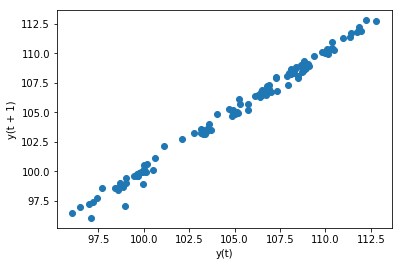

In [293]:
pd.plotting.lag_plot(data_monthly.CPI)
plt.savefig("1a0.png", dpi=150)
plt.show()

In [90]:
monthly_diff = data_monthly.diff()
monthly_diff.head()

,BPP,CPI
month_index,,
0,NaN,NaN
1,0.189097,0.525
2,-0.038471,-0.401
3,-1.167465,-0.139
4,-0.689135,-1.010


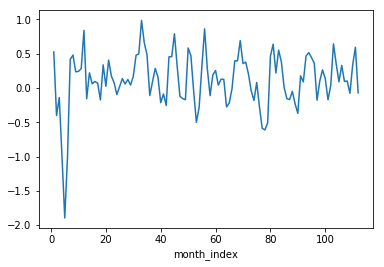

In [110]:
monthly_diff.CPI.plot()
plt.savefig("1a1.png", dpi=150)
plt.show()

In [80]:
############ 6.1(a) #################
from statsmodels import tsa
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

In [116]:
all_diff = monthly_diff.iloc[1:]
# split dataset
train = all_diff.iloc[0:56]
test = all_diff.iloc[56:]

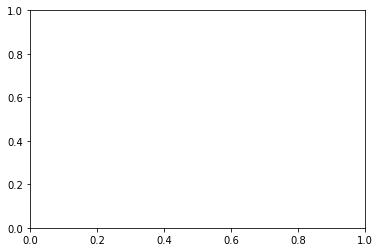

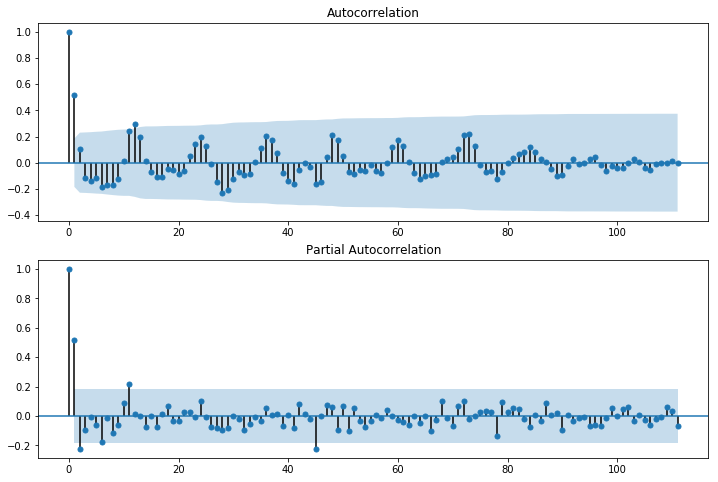

In [152]:
fig, ax = plt.subplots()
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(all_diff.CPI.values.squeeze(), ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(all_diff.CPI, ax=ax2)
plt.savefig("1a2.png", dpi=150)
plt.show()

In [115]:
model = tsa.ar_model.AR(train.CPI.values)
fit1 = model.fit(maxlag=1)
fit1.predict(start=len(train), end=len(train))

array([ 0.51436642])

In [147]:
def predict(order):
    train_set = train
    test_set = test
    model = tsa.ar_model.AR(train_set.CPI.values)
    fit = model.fit(maxlag = order)
    predictions = []
    for i in range(1, len(test)+1):
        result = fit.predict(start=len(train_set), end = len(train_set))
        predictions.append(result)
        train_set = all_diff.iloc[0:56+i]
        test_set = all_diff.iloc[56+i:]
        model = tsa.ar_model.AR(train_set.CPI.values)
        fit = model.fit(maxlag = order)      
    mse = mean_squared_error(predictions, test.CPI.values)
    return mse
predict(1)   

0.072031582422495744

In [149]:
ar_results = pd.DataFrame(index = range(1, 11), columns = ['mse'])
mses = []
for idx in ar_results.index.tolist():
    ar_results['mse'][idx] = predict(idx)
ar_results

,mse
1,0.0720316
2,0.0693829
3,0.0728249
4,0.0723737
5,0.077735
6,0.0762245
7,0.0775881
8,0.081464
9,0.0836255
10,0.0908201


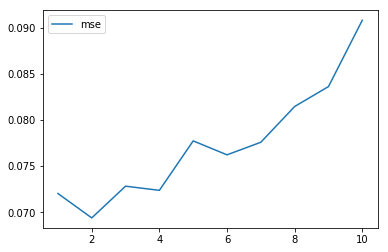

In [151]:
ar_results.plot()
plt.savefig("1a3.png", dpi=150)
plt.show()

In [301]:
model = tsa.ar_model.AR(train.CPI.values)
fit = model.fit(maxlag = 2)
fit.params

array([ 0.07284019,  0.70352742, -0.25816636])

In [184]:
############ 6.1(b) #################
ber_data = pd.read_csv(input_path + 'BER.csv', header = 0)

ber_data = ber_data.mask(ber_data == '.')
ber_data = ber_data.dropna()
ber_data['date1'] = ber_data.apply(lambda row: datetime.strptime(str(row['DATE']), '%x'), axis=1) 
ber_data['month_index'] = ber_data.apply(lambda row: diff_month(row.date1, ini_date), axis=1)
ber_data['BER'] = ber_data.apply(lambda row: float(row.T10YIE), axis=1)

In [190]:
monthly_ber = ber_data.groupby('month_index').agg({'BER':{'ber_avg': 'mean', 'ber_last': 'last'}})
monthly_ber.columns = monthly_ber.columns.droplevel(0)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/pandas/core/groupby.py:4189: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [192]:
monthly_other = data.groupby('month_index').agg({'CPI':{'CPI':'first'}, 'BPP':{'bpp_avg':'mean', 'bpp_last':'last'}})
monthly_other.columns = monthly_other.columns.droplevel(0)
monthly_other

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/pandas/core/groupby.py:4189: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


,bpp_avg,bpp_last,CPI
month_index,,,
0,100.000774,100.132,100.000000
1,100.189871,100.292,100.525000
2,100.151400,99.356,100.124000
3,98.983935,98.805,99.985000
4,98.294800,97.957,98.975000
5,97.252484,96.844,97.080000
6,97.126645,97.173,96.076000
7,97.263964,97.161,96.494000
8,97.382226,97.405,96.974000


In [193]:
monthly_all = monthly_ber.join(monthly_other, how='inner')

In [196]:
diff_df = monthly_all.diff().iloc[1:]
diff_df.head()

,ber_avg,ber_last,bpp_avg,bpp_last,CPI
month_index,,,,,
1,-0.229113,-0.19,0.189097,0.160,0.525
2,-0.373333,-0.55,-0.038471,-0.936,-0.401
3,-0.774372,-0.73,-1.167465,-0.551,-0.139
4,-0.423485,-0.54,-0.689135,-0.848,-1.010
5,-0.391970,-0.22,-1.042316,-1.113,-1.895


In [258]:
train_ex = diff_df.iloc[0:56]
test_ex = diff_df.iloc[56:]

def update_regressor(train_set, regres_names):
    regres_list = []
    for name in regres_names:
        regres_list.append(train_set[name].values)
    regressors = np.column_stack(regres_list)
    return regressors

def predict_ex(order, regres_names):
    train_set = train_ex
    test_set = test_ex
    ex_vars = update_regressor(train_set, regres_names)
    model = tsa.arima_model.ARIMA(endog = train_set.CPI.values, order = (order,0,0), exog = ex_vars)
    fit = model.fit()
    predictions = []
    for i in range(1, len(test)+1):
        result = fit.predict(start=len(train_set), end = len(train_set), exog = ex_vars)
        predictions.append(result[0])
        train_set = diff_df.iloc[0:56+i]
        test_set = diff_df.iloc[56+i:]
        ex_vars = update_regressor(train_set, regres_names)
        model = tsa.arima_model.ARIMA(endog = train_set.CPI.values, order = (order,0,0), exog = ex_vars)
        fit = model.fit()      
    mse = mean_squared_error(predictions, test_ex.CPI.values)
    return mse

In [259]:
predict_ex(1, ['ber_avg', 'bpp_avg'])

0.11152014693293325

In [260]:
predict_ex(2, ['ber_avg', 'bpp_avg'])

0.11150856813858136

In [265]:
ar_ex_results = pd.DataFrame(index = range(1, 4), columns = ['avg_mse', 'last_mse'])
for idx in ar_ex_results.index.tolist():
    ar_ex_results['avg_mse'][idx] = predict_ex(idx, ['ber_avg', 'bpp_avg'])
    ar_ex_results['last_mse'][idx] = predict_ex(idx, ['ber_last', 'bpp_last'])
ar_ex_results

,avg_mse,last_mse
1,0.11152,0.0989435
2,0.111509,0.0952301
3,0.114315,0.106543


In [267]:
print(ar_ex_results.to_latex())

\begin{tabular}{lll}
\toprule
{} &   avg\_mse &   last\_mse \\
\midrule
1 &   0.11152 &  0.0989435 \\
2 &  0.111509 &  0.0952301 \\
3 &  0.114315 &   0.106543 \\
\bottomrule
\end{tabular}



In [303]:
ex_vars = update_regressor(train_ex, ['ber_last', 'bpp_last'])
model = tsa.arima_model.ARIMA(endog = train_ex.CPI.values, order = (2,0,0), exog = ex_vars)
fit = model.fit()
print(fit.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   56
Model:                     ARMA(2, 0)   Log Likelihood                 -22.849
Method:                       css-mle   S.D. of innovations              0.363
Date:                Fri, 01 Dec 2017   AIC                             57.697
Time:                        22:59:00   BIC                             69.849
Sample:                             0   HQIC                            62.409
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0612      0.072      0.850      0.399      -0.080       0.202
x1            -0.2376      0.203     -1.173      0.246      -0.635       0.160
x2             0.4574      0.173      2.638      0.0

In [270]:
############ 6.1(c) #################

In [290]:
def predict_am(order_am, regres_names):
    train_set = train_ex
    test_set = test_ex
    ex_vars = update_regressor(train_set, regres_names)
    model = tsa.arima_model.ARIMA(endog = train_set.CPI.values, order = (2,0,order_am), exog = ex_vars)
    fit = model.fit()
    predictions = []
    for i in range(1, len(test)+1):
        result = fit.predict(start=len(train_set), end = len(train_set), exog = ex_vars)
        predictions.append(result[0])
        train_set = diff_df.iloc[0:56+i]
        test_set = diff_df.iloc[56+i:]
        ex_vars = update_regressor(train_set, regres_names)
        model = tsa.arima_model.ARIMA(endog = train_set.CPI.values, order = (2,0,order_am), exog = ex_vars)
        fit = model.fit(method = 'css')      
    mse = mean_squared_error(predictions, test_ex.CPI.values)
    return mse

In [291]:
predict_am(1, ['ber_avg', 'bpp_avg'])

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Library/Frameworks/Python.frame

0.12543173529810667

In [292]:
predict_am(1, ['ber_last', 'bpp_last'])

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Library/Frameworks/Python.frame

0.10137106613948697